In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 34.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.4 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.1 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.5 MB/s eta 0:00:00


In [2]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
import networkx as nx
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
df = pd.concat([pd.read_csv('atlantic.csv'), pd.read_csv('pacific.csv')]).reset_index(drop=True)
# Convert date column as datetime.
df['Date'] = pd.to_datetime(df['Date'] , format= '%Y%m%d')

In [4]:
df.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],
      dtype='object')

In [5]:
# I want to create columns Latitude Hemisphere and Longitude Hemisphere with code 0 = N , 1 = S & 0 = E , 1 = W.
def hemisphere(coord):
        hem = re.findall(r'[NSWE]' , coord)[0]
        if hem == 'N' or hem == 'E':
            return 0
        else:
            return 1

# Creating the column Latitude_Hemisphere.
df['Latitude_Hemisphere'] = df['Latitude'].apply(hemisphere)
df['Longitude_Hemisphere'] = df['Longitude'].apply(hemisphere)
df['Latitude_Hemisphere'] = df['Latitude_Hemisphere'].astype('category')
df['Longitude_Hemisphere'] = df['Longitude_Hemisphere'].astype('category')

# Convert the latitude and longitude Column to numeric type.
df['Latitude'] =  df['Latitude'].apply(lambda x: re.match('[0-9]{1,3}.[0-9]{0,1}' , x)[0])
df['Longitude'] =   df['Longitude'].apply(lambda x: re.match('[0-9]{1,3}.[0-9]{0,1}' , x)[0])

# The missing values are given by -999. So , we need to fill them appropriately.

# Show the count of missing values and fill them with mean.
for column in df.columns:
    missing_cnt = df[column][df[column] == -999].count()
    print('Missing Values in column {col} = '.format(col = column) , missing_cnt )
    if missing_cnt!= 0:
#         print('in ' , column)
        mean = round(df[column][df[column] != -999 ].mean())
#         print("mean",mean)
        index = df.loc[df[column] == -999 , column].index
#         print("index" , index )
        df.loc[df[column] == -999 , column] = mean
#         print(df.loc[index , column])

# Restructure the dataframe for visibility and remove columns ID and Event.
df =  df[['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude', 'Latitude_Hemisphere' ,
       'Longitude', 'Longitude_Hemisphere' ,'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']]

# Change all time to format HHMM.
df['Time'] = df['Time'].astype('object')
def hhmm(time):
    time = str(time)
    digits = re.findall(r'\d', time)
    t = ''
    if len(digits) == 1:
        t ='0{i}00'.format(i =time)
    elif len(digits) == 2:
        t = '00{i}'.format(i =time)
    elif len(digits) == 3:
        t = '0{i}'.format(i =time)
    else:
        t = time
    return t

# Apply the function.
df['Time'] = df['Time'].apply(hhmm)

# Convert the column into Datetime.
df['Time'] = pd.to_datetime(df['Time'] , format='%H%M').dt.time


# Convert the status column to categorical.
df['Status'] = df['Status'].astype('category')

data = df.drop(columns = ['ID' , 'Event'])

Missing Values in column ID =  0
Missing Values in column Name =  0
Missing Values in column Date =  0
Missing Values in column Time =  0
Missing Values in column Event =  0
Missing Values in column Status =  0
Missing Values in column Latitude =  0
Missing Values in column Longitude =  0
Missing Values in column Maximum Wind =  0
Missing Values in column Minimum Pressure =  43473
Missing Values in column Low Wind NE =  62934
Missing Values in column Low Wind SE =  62934
Missing Values in column Low Wind SW =  62934
Missing Values in column Low Wind NW =  62934
Missing Values in column Moderate Wind NE =  62934
Missing Values in column Moderate Wind SE =  62934
Missing Values in column Moderate Wind SW =  62934
Missing Values in column Moderate Wind NW =  62934
Missing Values in column High Wind NE =  62934
Missing Values in column High Wind SE =  62934
Missing Values in column High Wind SW =  62934
Missing Values in column High Wind NW =  62934
Missing Values in column Latitude_Hemisp

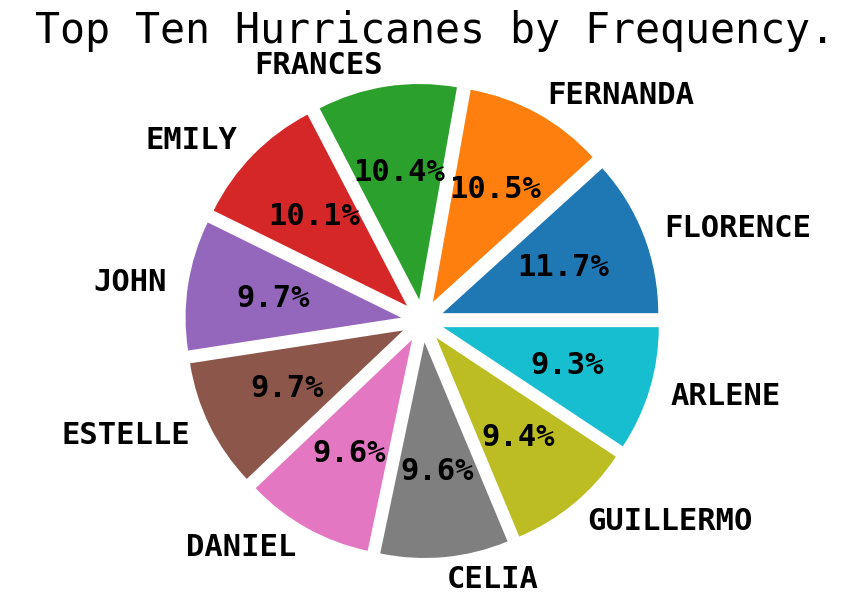

In [6]:
# Find the top ten cyclones which have occured the maximum number of times.
lst = [x.strip() for x in data[data["Name"] != "            UNNAMED"].groupby('Name').count().sort_values(by = 'Date' , ascending = False).index[:10]]
val = data[data["Name"] != "            UNNAMED"].groupby('Name').count().sort_values(by = 'Date' , ascending = False)[:10]['Date'].values
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
fig , ax = plt.subplots()
fig.set_size_inches(7,7)
ax.pie(  labels = lst , x = val , autopct='%.1f%%' , explode = [0.1 for x in range(10)])
plt.title(' Top Ten Hurricanes by Frequency.' , fontsize = 30)
plt.show()

<ipython-input-7-5e6b95b7f716>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = temp.index , y = 'Date' , data=temp , palette = 'RdBu' )


Text(0.5, 1.0, 'Frequency of Cyclones by Month.')

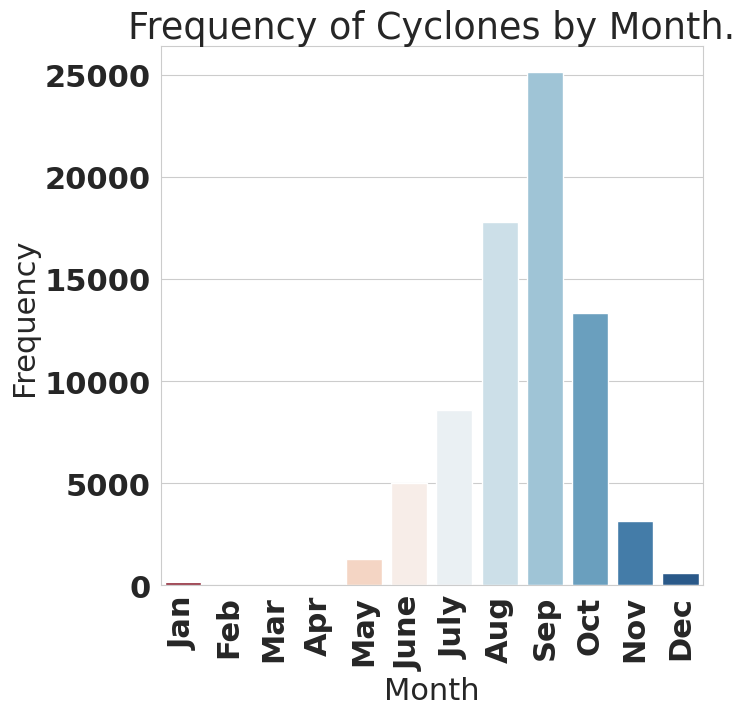

In [7]:
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Year'] = data['Date'].apply(lambda x: x.year)
mnt = ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 'June' , 'July' , 'Aug' , 'Sep','Oct' , 'Nov' , 'Dec']
temp = data.groupby('Month').count()
temp.loc[4] = 0
temp = temp.sort_values(by = 'Month' , ascending = False)
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize = (7,7))
sns.set_style("whitegrid")
ax = sns.barplot(x = temp.index , y = 'Date' , data=temp , palette = 'RdBu' )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11] , mnt , rotation = 90)
plt.ylabel('Frequency')
plt.title('Frequency of Cyclones by Month.')

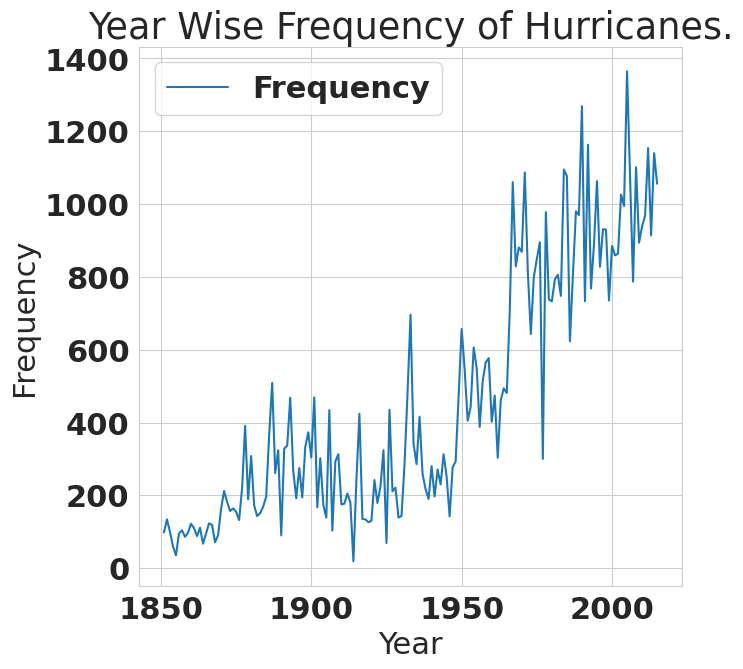

In [8]:
# Year-Wise Frequency of Hurricanes.
temp = data.groupby('Year').count().sort_values(by = 'Month' , ascending = False)
plt.figure(figsize= (7,7))
sns.lineplot(x = temp.index , y = 'Month' , data = temp , label = 'Frequency')
plt.ylabel('Frequency')
plt.title('Year Wise Frequency of Hurricanes.')
plt.show()

<ipython-input-9-17ef7a740165>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['Date'].values , norm_hist = True , axlabel = 'Probability Distribution of Frequency of Cyclones.')


<Axes: xlabel='Probability Distribution of Frequency of Cyclones.', ylabel='Density'>

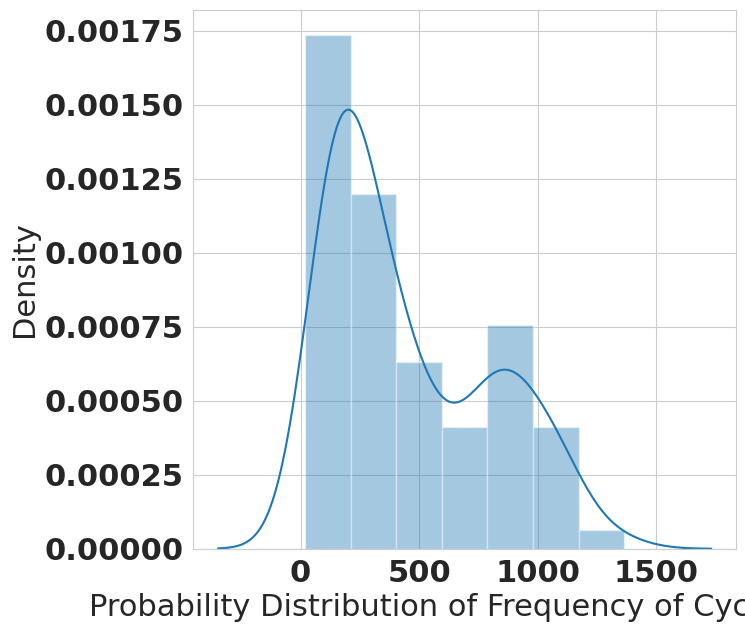

In [9]:
# Probability Distribution Function of Frequency.
temp = data.groupby('Year').count().sort_values(by = 'Date' , ascending = False)
plt.figure(figsize=(7,7))
sns.distplot(temp['Date'].values , norm_hist = True , axlabel = 'Probability Distribution of Frequency of Cyclones.')

<ipython-input-10-cf14490aeab3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = list(temp.index) , x = 'Date' , data = temp, palette= 'pastel' )


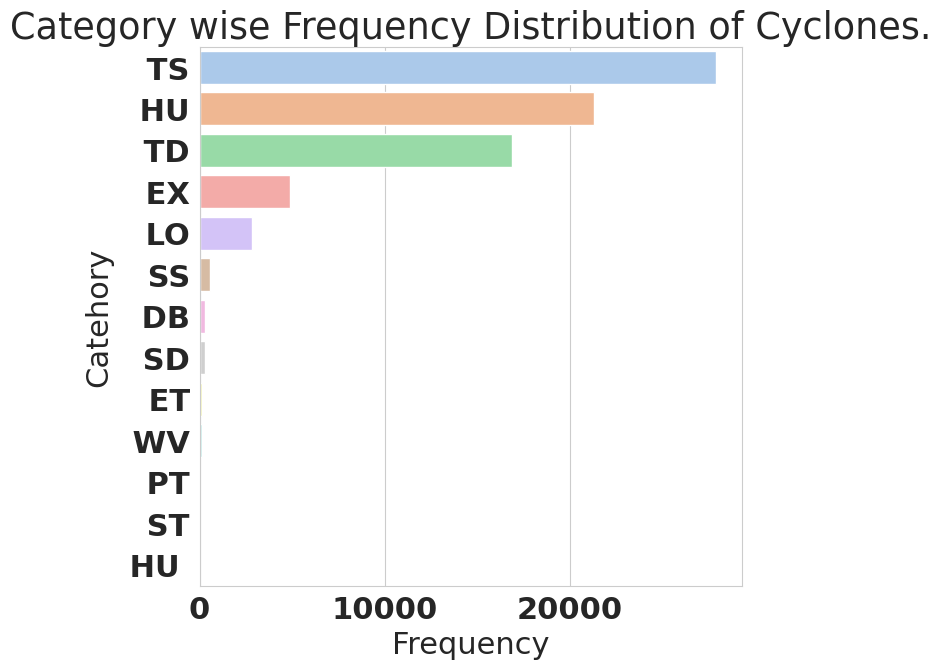

In [10]:
## Frequency of Cyclones by Category
# TD – Tropical cyclone of tropical depression intensity (< 34 knots)
# TS – Tropical cyclone of tropical storm intensity (34-63 knots)
# HU – Tropical cyclone of hurricane intensity (> 64 knots)
# EX – Extratropical cyclone (of any intensity)
# SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
# SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
# LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
# WV – Tropical Wave (of any intensity)
# DB – Disturbance (of any intensity)
temp = data.groupby('Status').count().sort_values(by = 'Date' , ascending = False)
fig , ax = plt.subplots()
fig.set_size_inches(7,7)
sns.barplot(y = list(temp.index) , x = 'Date' , data = temp, palette= 'pastel' )
plt.xlabel('Frequency')
plt.ylabel('Catehory')
plt.title('Category wise Frequency Distribution of Cyclones.')
plt.show()

In [11]:
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Latitude_Hemisphere,Longitude,Longitude_Hemisphere,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,1851-06-25,00:00:00,,HU,28.0,0,94.8,1,...,37,47,19,17,12,15,7,6,4,5
1,AL011851,UNNAMED,1851-06-25,06:00:00,,HU,28.0,0,95.4,1,...,37,47,19,17,12,15,7,6,4,5
2,AL011851,UNNAMED,1851-06-25,12:00:00,,HU,28.0,0,96.0,1,...,37,47,19,17,12,15,7,6,4,5
3,AL011851,UNNAMED,1851-06-25,18:00:00,,HU,28.1,0,96.5,1,...,37,47,19,17,12,15,7,6,4,5
4,AL011851,UNNAMED,1851-06-25,21:00:00,L,HU,28.2,0,96.8,1,...,37,47,19,17,12,15,7,6,4,5


### Graph representation

In [12]:
def weight_for_edge(i, j):
    if j == i + 1:
        return 1
    elif (j == i + 2) or (j == i + 3):
        return 0.5
    elif (j == i + 4) or (j == i + 5):
        return 0.1
    else:
        return 0

def get_local_graph(graph, node):
    graph_copy = graph.copy()
    subgraph = nx.reverse(nx.ego_graph(nx.reverse(graph_copy), node, radius=1))

    attr_node_0 = subgraph.nodes[list(subgraph.nodes)[0]]["localisation"]
    for node in subgraph.nodes:
        subgraph.nodes[node]["localisation"] = subgraph.nodes[node]["localisation"] - attr_node_0

    return subgraph

def get_dic_graph(df, loc_feature_names, weather_feature_names, max_seq_lenght=16):
    dic_graph = {}
    dic_X = {}
    dic_Y = {}

    for hurricane in df["ID"].unique():
        df_hurr = df[df["ID"] == hurricane]

        if len(df_hurr) > 2:
            y_index = random.randint(2, len(df_hurr)-1)
            y = df_hurr[loc_feature_names].iloc[y_index].apply(float)

            x = df_hurr[loc_feature_names + weather_feature_names].iloc[:y_index].iloc[-max_seq_lenght:].applymap(float)

            # Standardization of weather features
            scaler = StandardScaler()
            x[weather_feature_names] = scaler.fit_transform(x[weather_feature_names])

            graph = nx.DiGraph()
            for i in range(len(x)):
                graph.add_node(i, localisation=x[loc_feature_names].values[i], weather=x[weather_feature_names].values[i])

            for i in range(len(x)):
                for j in range(i+1, len(x)):
                    if i + 5 >= j:
                        graph.add_edge(i, j, weight=weight_for_edge(i,j))

            # Localisation features to local co-ordinates
            attr_node_0 = graph.nodes[list(graph.nodes)[0]]["localisation"]
            for node in graph.nodes:
                graph.nodes[node]["localisation"] = graph.nodes[node]["localisation"] - attr_node_0

            # It would take approximately 1 hour to compute the local graph for all nodes.
            # for node in graph.nodes:
            #     graph.nodes[node]["subgraph"] = get_local_graph(graph, node)


            dic_graph[hurricane] = graph
            dic_X[hurricane] = x
            dic_Y[hurricane] = y

    return dic_graph, dic_X, dic_Y

In [13]:
weather_feature_names = ['Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE',
       'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE',
       'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE',
       'High Wind SW', 'High Wind NW']
dic_graph, dic_X, dic_Y = get_dic_graph(df, loc_feature_names=["Latitude", "Longitude"], weather_feature_names=weather_feature_names)

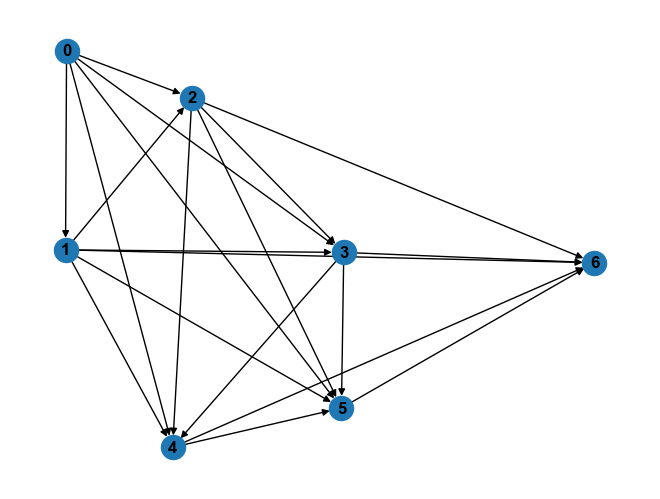

In [ ]:
nx.draw(dic_graph["AL011851"], with_labels=True, font_weight='bold')
# labels = {e: dic_graph["AL011851"].edges[e]['weight'] for e in dic_graph["AL011851"].edges}
# nx.draw_networkx_edge_labels(dic_graph["AL011851"], pos = nx.spring_layout(dic_graph["AL011851"], k=10), edge_labels=labels)
plt.show()

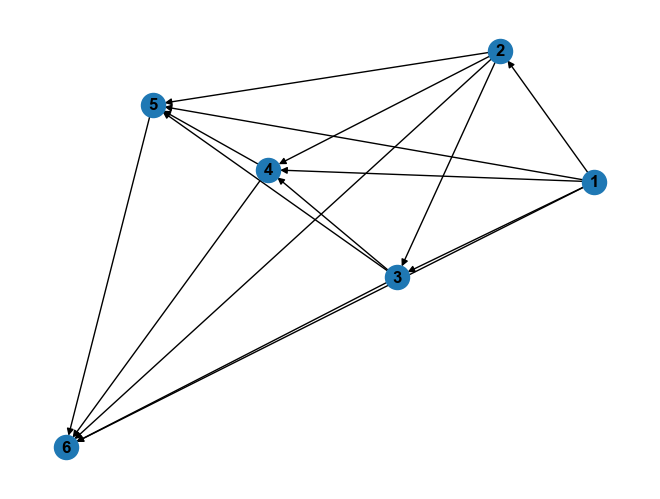

In [ ]:
nx.draw(get_local_graph(dic_graph["AL011851"], 6), with_labels=True, font_weight='bold')

In [ ]:
get_local_graph(dic_graph["AL011851"], 6).nodes(data=True)

NodeDataView({1: {'localisation': array([0., 0.]), 'weather': array([0.58834841, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}, 2: {'localisation': array([0. , 0.6]), 'weather': array([0.58834841, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}, 3: {'localisation': array([0.1, 1.1]), 'weather': array([0.58834841, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}, 4: {'localisation': array([0.2, 1.4]), 'weather': array([0.58834841, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}, 5: {'localisation': 

#### Training dataset

In [44]:
training_data = []
batch_size = 1

for hurricane in dic_graph:
    x = torch.tensor(np.array([np.concatenate(list(dic_graph[hurricane].nodes.data()[i].values())) for i in range(len(dic_graph[hurricane].nodes))]), dtype=torch.float)

    # Convert labels to PyTorch tensor
    y_train = torch.tensor(dic_Y[hurricane].values, dtype=torch.float).unsqueeze(0)

    # Convert edge indices to PyTorch tensor
    edge_index_train = torch.tensor(list(dic_graph[hurricane].edges()),dtype=torch.long).transpose(0, 1)

    # create edge features
    edge_attr_train = torch.tensor([dic_graph[hurricane].edges()[edge]["weight"] for edge in dic_graph[hurricane].edges()], dtype=torch.float)

    data = Data(x=x, edge_index=edge_index_train, edge_attr=edge_attr_train, y=y_train)
    training_data.append(data)

print(f"Training data size: {len(training_data)}")
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

Training data size: 2831


#### Model architecture

In [45]:
from torch_geometric.nn import GCNConv, GATv2Conv

class Model(nn.Module):
  def __init__(self, input_size_gcn, hidden_size_gcn, output_size_gcn, wind_features_size, nhead_transformer, output_size_transformer, num_layers_transformer, output_size):
    super().__init__()

    self.conv1 = GCNConv(input_size_gcn, hidden_size_gcn)
    self.conv2 = GCNConv(hidden_size_gcn, output_size_gcn)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=output_size_gcn + wind_features_size, nhead=nhead_transformer, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers_transformer)
    self.fc = nn.Linear(output_size_gcn + wind_features_size, output_size_transformer)

    self.linear = nn.Linear(output_size_transformer, output_size)

    self.elu = nn.ELU()

  def forward(self, x, edge_index):
    loc_features = x[:, :2]
    wind_features = x[:, 2:]

    # Graph convolution
    loc_features = self.conv1(loc_features, edge_index)
    loc_features = self.elu(loc_features)
    loc_features = self.conv2(loc_features, edge_index)
    loc_features = self.elu(loc_features)

    # Transformer encoder
    concatenated_input = torch.cat((loc_features, wind_features), dim=1)
    transformer_output = self.transformer_encoder(concatenated_input.unsqueeze(0))
    transformer_output = self.fc(transformer_output.squeeze())
    transformer_output = transformer_output[-1, :]  # Extract representation of the final token

    # Final linear layer
    output = self.linear(transformer_output)
    output = self.elu(output)

    return output.unsqueeze(0)

In [46]:
def evaluate(model, loss_fcn, device, dataloader):
    loss_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)

        loss_list_batch.append(loss_test.item())

    return np.array(loss_list_batch).mean()

In [47]:
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader, scheduler = None):

    epoch_list = []
    scores_list = []
    all_losses= []
    best_model_state_dict = None
    best_score = 0

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []

        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            output = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(output, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        loss_data = np.array(losses).mean()
        all_losses.append(loss_data)
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if scheduler is not None:
            scheduler.step()

        # if epoch % 5 == 0:
        #     # evaluate the model on the validation set
        #     score = evaluate(model, loss_fcn, device, val_dataloader)
        #     print("Loss on val set: {:.4f}".format(score))
        #     scores_list.append(score)
        #     epoch_list.append(epoch)
        #     # Check if the current model is the best one so far
        #     if score > best_score:
        #         best_score = score
        #         best_model_state_dict = model.state_dict()
    # Load the best model parameters
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
    return epoch_list, scores_list, all_losses


In [48]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Create the GAT model
model = Model(input_size_gcn=2,
              hidden_size_gcn=18,
              output_size_gcn=18,
              wind_features_size=x.shape[1]-2,
              nhead_transformer=4,
              output_size_transformer=64,
              num_layers_transformer=4,
              output_size=2).to(device)

# Define the loss function and optimizer
loss_fcn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_epochs=30


Device:  cuda


In [49]:
train(model, loss_fcn, device, optimizer, max_epochs, train_loader, val_dataloader=None, scheduler=scheduler)

Epoch 00001 | Loss: 24.7398
Epoch 00002 | Loss: 15.1171
Epoch 00003 | Loss: 14.5554
Epoch 00004 | Loss: 14.1218
Epoch 00005 | Loss: 13.7072
Epoch 00006 | Loss: 13.3299
Epoch 00007 | Loss: 13.1401
Epoch 00008 | Loss: 12.9873
Epoch 00009 | Loss: 12.8235
Epoch 00010 | Loss: 12.7189
Epoch 00011 | Loss: 12.6944
Epoch 00012 | Loss: 12.5325
Epoch 00013 | Loss: 12.4588
Epoch 00014 | Loss: 12.2634
Epoch 00015 | Loss: 12.3251
Epoch 00016 | Loss: 12.1444
Epoch 00017 | Loss: 12.2365
Epoch 00018 | Loss: 12.0978
Epoch 00019 | Loss: 12.0616
Epoch 00020 | Loss: 12.0046
Epoch 00021 | Loss: 11.6438
Epoch 00022 | Loss: 11.5872
Epoch 00023 | Loss: 11.6266
Epoch 00024 | Loss: 11.4852
Epoch 00025 | Loss: 11.5141
Epoch 00026 | Loss: 11.4206
Epoch 00027 | Loss: 11.4925
Epoch 00028 | Loss: 11.4250
Epoch 00029 | Loss: 11.3541
Epoch 00030 | Loss: 11.3359


([],
 [],
 [24.739775906702164,
  15.11710204224815,
  14.555441572170023,
  14.121775583249915,
  13.707233564894619,
  13.329866742675105,
  13.140081635589146,
  12.987262671649294,
  12.823543451825786,
  12.718916936614608,
  12.694356913842505,
  12.532462131923525,
  12.458762539176949,
  12.2634198613753,
  12.325066301655859,
  12.144418267669954,
  12.236530115306538,
  12.09776968292034,
  12.061587909170099,
  12.004589410615853,
  11.64376797483782,
  11.587166173733374,
  11.62656364240955,
  11.485209823058703,
  11.514088052511479,
  11.420620643238678,
  11.49250339482839,
  11.42499884312623,
  11.354107947229249,
  11.335878232501562])

In [57]:
training_data[0].y

tensor([28.4000, 98.3000])

In [58]:
model.eval()
model(training_data[0].x.to(device), training_data[0].edge_index.to(device))

tensor([ 17.0988, 106.5093], device='cuda:0', grad_fn=<EluBackward0>)

In [55]:
training_data[1].y

tensor([21.2000, 79.0000])

In [56]:
model.eval()
model(training_data[1].x.to(device), training_data[1].edge_index.to(device))

tensor([19.2888, 80.1740], device='cuda:0', grad_fn=<EluBackward0>)